In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.precision', 3)

## Gap Trading Signal

### Introduction

**The idea of this strategy is to chase the momentum in a financial market where information dissipates not all at once.**
For example, after a strong earnings report, a single stock can open at a very high level on the next trading day compared to the closing price from the previous trading day. We observe that this uptick continues throughout the next trading day. Therefore, there are opportunities for traders to take advantage of.

In this project, our trading universe is 100 stocks from S&P 100 index (excluding META due to data quality issues), between 2010-01-04 and 2022-12-30.

Further research are performed on **optimal lookback window, optimal holding period, optimal portfolio construction, max profit/loss threshold, inverse signals**, etc. 

### Methodology
**Formally, the strategy generates a buy signal for a single stock when the gap between open price at trading day t and close price at trading day t-1 is considered significant over a fixed period of look back window.** A mathematical explanation of a gap being "significant" is as follows,<br><br>

*Consider a fixed-length look back window $W$= 50 trading days. The open gap $gap_{t,i}$ for stock $i$ is defined as<br><br>
$$
gap_{t,i} = S_{open,t,i} - S_{Close,t-1,i},
$$<br>
where $S_{open,t,i}$ is the open price of stock $i$ at trading day t, and $S_{Close,t-1,i}$ is the close price of stock $i$ at trading day t-1.<br><br>
For stock $i$, we obtain a time series $G_{i}$ = {$gap_{s-49,i}$, $gap_{s-48,i}$, $gap_{s-47,i}$,..., $gap_{s,i}$}, where $s$ corresponds to the last trading day in the look back window $W$.
For a significance level of 90%, $gap_{s,i}$ is considered significant if and only if $gap_{s,i}$ is at least in the 90th-percentile of $G_{i}$. Under this case, our strategy will generate a buy signal for stock $i$ on trading day $s$ at open. Since $gap_{s,i}$ is available information on trading day $s$ as soon as market opens, this strategy does not have look ahead bias.*<br>

**Following a buy signal, we enter a long position of stock $i$ at open, and close the position before the trading session ends.** In other words, the most possible holding period for this strategy is one trading day, as we try to avoid position overlay in the next trading day. The rationale is simple and straightforward. Consider a scenario where we still hold 10 shares of AAPL following a buy signal after the trading session ends, and there is another buy signal for AAPL on the next trading day. Given that we currently have a positive position in AAPL, do we buy more shares of AAPL as the signal suggests? If so, how much more capital should we allocate to AAPL? If we do not buy more shares, and there is a signal for a different stock on the same day, how should we construct an equal-weight portfolio? To avoid spending further resources on these questions, we can simply decide that we must close out our position at the end of trading session and only hold cash overnight. 

**The holding period can vary from 15 minutes to one trading session, depending on empirical results.** In this project, we explore different holding periods and see on average if there is an optimal exit time for this strategy. This is borrowing an intraday return framework in a previous project of mine, with details here: https://github.com/shaoyuliu98/Quantitative-Research/blob/26f7677be1b767446ae0b9a3fb5aa0ee6189f845/Intraday%20Return%20Analysis.ipynb. We try to see if applying a signal will vastly improve the empirical results. We also apply other classic exit signals such as SMA crossovers in combination with the analysis above, hoping to optimize the trading strategy without overfitting.

### Signal Generation
**The below example is signals generated using the parameters mentioned above, namely a look back window of 50 trading days and a siginificance level of 90%.** 1 represents a buy signal, and 0 represents no action. The rows indicate any date where a trading signal is generated, and columns correspond to the tickers in our trading universe.

In [18]:
signals = pd.read_csv('./signals/Open Gap Signals/SP 100/sp100_signal_50rolling_90lvl.csv')

In [19]:
# drop META due to data quality issues
selected = [i for i in signals.columns if i!='META']
signals = signals[selected]
signals.set_index('Date',inplace=True)
# drop any days without signals (coming from META)
signals = signals.loc[~(signals==0).all(axis=1)]

signals.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2010-03-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-23,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Signal Characteristics
**We plot the heatmap for all signals generated in 2022 as an example.** Baige areas indicate buy signals, whereas black areas indicate no trading activities. An interesting observation is that we see certain dates where there is a buy signal for most stocks in our trading universe, such as Mar 9, Oct 18, Nov 10, and Dec 13, all of which have at least 85 buy signals out of 100 stocks. This massive scale of signals indicates that there must have been some positive macroeconomic news overnight or before the opening bell that drives the market in the upward direction. 

For instance, CPI data was released in the morning of November 10th, 2022, just ahead of market open, and the results were better than expected in October. This suggested that the pressure from inflation could be starting to "cool down", thus creating a positive sentiment around the market, as S&P 500 opened over 3% higher. See full story and news release from CNBC: https://www.cnbc.com/2022/11/10/consumer-prices-rose-0point4percent-in-october-less-than-expected-as-inflation-eases.html.

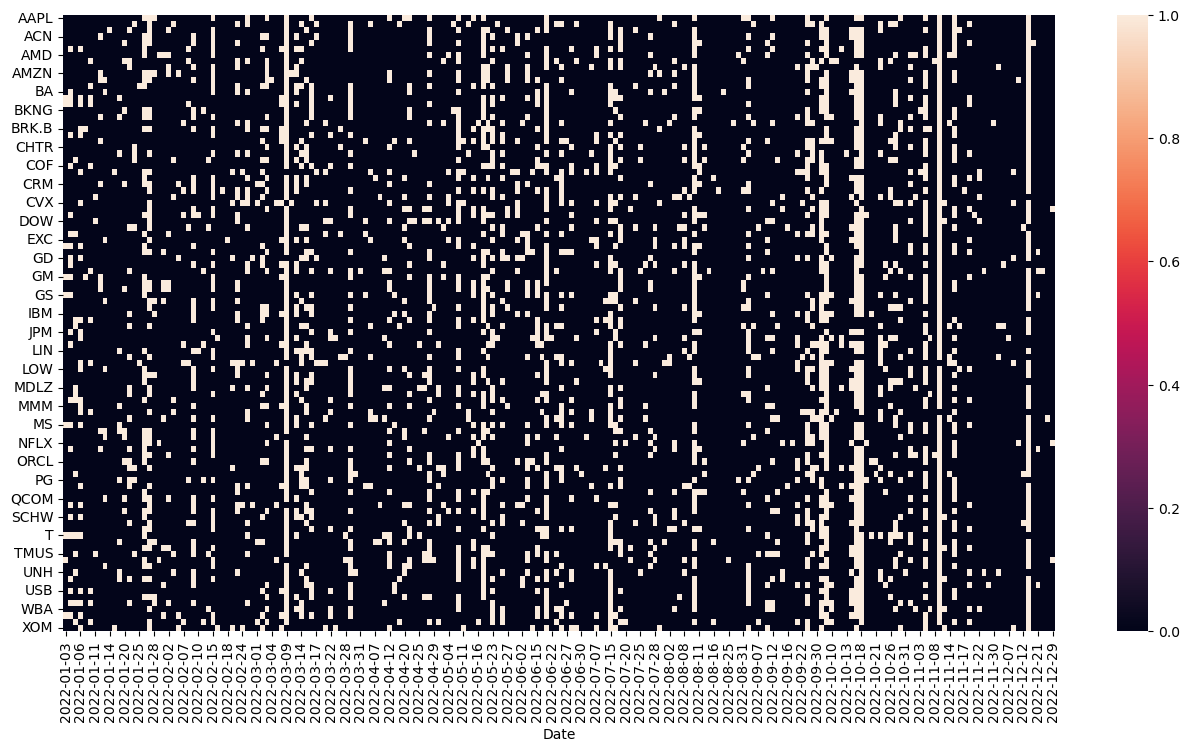

In [20]:
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(signals.loc['2022-01-01':'2022-12-31',:].T)
plt.show()

**We also plot the total number of trades by month to see if there is a seasonality effect.** As the chart below suggests, we see peaks appear around Jan, Mar, Jun, and Oct, all around or before earnings season. This makes a lot of economic sense because there will likely be some changes in these companies' fundamental values as earnings come out, thus shifting their corresponding "fair price" in the market. 

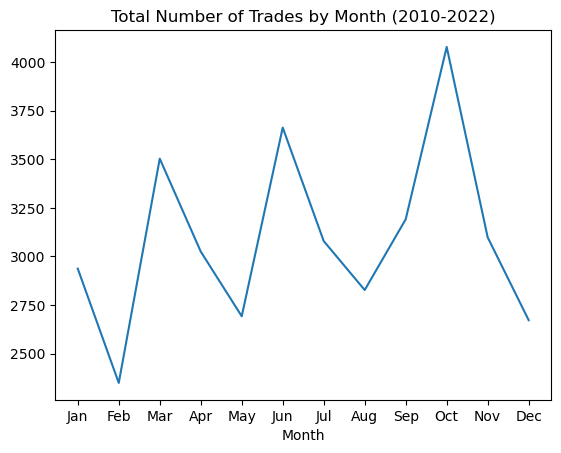

In [21]:
fig, ax = plt.subplots()
signals.groupby(pd.to_datetime(signals.index).month).sum().sum(axis=1).plot(ax=ax)
plt.title('Total Number of Trades by Month (2010-2022)')
plt.xlabel('Month')
plt.xticks(np.arange(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

**We analyze the frequency of signals as well.** In aggregate, we calculate the percentage of time we are in the market by taking the delta of two nearest trading days with at least one signals. The table and graph below suggest that we are actively trading in the market.

Summary Statistics:
count    2802.000
mean        1.667
std         1.145
min         1.000
25%         1.000
50%         1.000
75%         2.000
max         8.000
Name: Date, dtype: float64


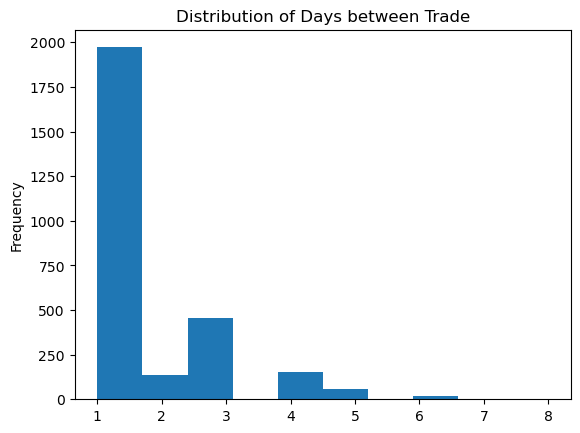

In [27]:
dist_trade_break = pd.to_datetime(pd.Series(signals.index)).diff().apply(lambda x:x.days)

print('Summary Statistics:')
print(dist_trade_break.describe())

dist_trade_break.plot.hist()
plt.title('Distribution of Days between Trade')
plt.show()

In [8]:
# strat_pnl_summary = strat_pnl.groupby(['year','Time']).describe().droplevel(0,axis=1)[['mean','std','min','max']].unstack()

In [9]:
# strat_pnl_summary['mean'].T.plot().legend(bbox_to_anchor=(1, 1))

In [10]:
# strat_pnl_summary['std'].T.plot().legend(bbox_to_anchor=(1, 1))

In [11]:
# (strat_pnl_summary['mean']/strat_pnl_summary['std']).T.plot().legend(bbox_to_anchor=(1, 1))

In [12]:
# strat_pnl.groupby(['year','Time'])['Open_to_Date_Return'].count().groupby('year').mean().round()

In [13]:
# strat_pnl.groupby(['Day','Time'])['Open_to_Date_Return'].mean().unstack()['15:45'].plot()

In [14]:
# for i in ['09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15','11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15',
#        '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15','15:30', '15:45']:
#     print(i,sum(strat_pnl.groupby(['Day','Time'])['Open_to_Date_Return'].mean().unstack()[i]>0)/len(strat_pnl.groupby(['Day','Time'])['Open_to_Date_Return'].mean().unstack()[i]))